 ## Processing and Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import make_pipeline

sns.set()

### Relevant Functions

In [2]:
def plot_confusion_matrix(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);

In [3]:
def plot_auc_curve(fpr, tpr):
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [4]:
def feature_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns
    plt.figure(figsize = (8,6))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [5]:
def model_coeff(model, X):
    print("Model coefficients:\n")
    for i in range(X.shape[1]):
        print(X.columns[i], "=", model.coef_[0,i].round(4))

In [6]:
def plot_impfeatures(models, model_label, ncol=None):
    if ncol is None:
        ncol = 2
    nrow = int(np.ceil(len(models) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8*nrow), squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, model in enumerate(models):
        ax = axes.flatten()[i]
        print(model)
        importances = model.feature_importances_
        indices = np.argsort(importances)
        features = X_train.columns
        
        ax.barh(range(len(indices)), importances[indices], color='b', align='center')
        ax.set(title=model_label[i])
        ax.set(xlabel='Relative Importance')
        ax.set_yticks(range(len(indices)), [features[i] for i in indices])
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [7]:
def plot_shap_summary(models, model_label, ncol=None):
    if ncol is None:
        ncol = 2
    nrow = int(np.ceil(len(models) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8*nrow), squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, model in enumerate(models):
        ax = axes.flatten()[i]
        explainer = shap.Explainer(model.predict,X_test)
        lr_shap_values = explainer(X_test)
        #summary_plot
        shap.plots.beeswarm(lr_shap_values)
        plt.title(model_label[i])
        #ax.set(title=model_label[i])
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [8]:
def auc_score(model, y_test, X_test):
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    return auc_score

In [9]:
def shap_values(model):
    explainer = shap.Explainer(model.predict,X_train[0:100])
    shap_values = explainer(X_test)
    return shap_values

In [10]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn import metrics

In [11]:
final_df = pd.read_csv('../clean_data/final_df.csv')
final_df.head()

,step,amount,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,281,109339.40,0,0,1,0,0,0
1,381,32426.51,0,1,0,0,0,0
2,20,55810.86,0,1,0,0,0,0
3,331,50514.72,0,0,1,0,0,0
4,182,16539.44,0,0,0,0,1,0


In [12]:
y = final_df['isFraud']
X = final_df.drop(columns = 'isFraud')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

## Model 1: Logistic Regression

### 1.1 Make Pipeline and fit

In [14]:
from sklearn.linear_model import LogisticRegression

LR_pipe = LogisticRegression()

In [15]:
LR_pipe.fit(X_train, y_train)

LogisticRegression()

In [16]:
model_name = LR_pipe

### 1.2 Hyperparameter search using GridSearchCV

In [17]:
model_name.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [18]:
grid_params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

In [19]:
lr_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)

In [20]:
lr_grid_cv.fit(X_train, y_train)


35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [21]:
lr_grid_cv.best_params_

{'C': 0.001, 'penalty': 'l2'}

### 1.3 Model Tuneup using best params

In [22]:
lr2=LogisticRegression(C=0.001,penalty="l2")
lr2.fit(X_train,y_train)
print("score",lr2.score(X_test,y_test))

score 0.6148312119535141


In [23]:
y_pred_lr2 = lr2.predict(X_test)

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_lr2)
metrics.auc(fpr, tpr)

0.6162410220697413

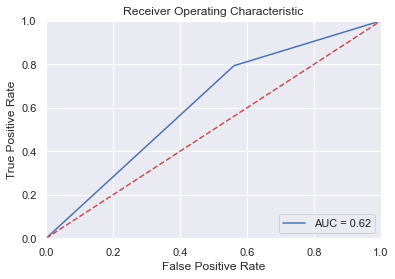

In [25]:
plot_auc_curve(fpr, tpr)

## Model 2: Random Forest

### 2.1 Make pipeline and fit

In [26]:
# Import the model
from sklearn.ensemble import RandomForestRegressor

In [27]:
# Instantiate model with 1000 decision trees
#RF_pipe = RandomForestRegressor(n_estimators = 1000, random_state = 42)
RF_pipe = RandomForestRegressor(random_state = 42)

In [28]:
# Train the model on training data
RF_pipe.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [29]:
model_name = RF_pipe

### 2.2 Hyperparameter search using GridSearchCV

In [30]:
model_name.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [31]:
grid_params = { 
    'n_estimators': [1000],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [32]:
rf_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)

In [33]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1000]})

In [34]:
rf_grid_cv.best_params_

{'max_features': 'auto', 'n_estimators': 1000}

### 2.3 Model Tuneup using best params

In [35]:
rf2=RandomForestRegressor(max_features= 'auto', n_estimators= 1000)
rf2.fit(X_train,y_train)
print("score",rf2.score(X_test,y_test))

score 0.6718293464732408


In [36]:
y_pred_rf = rf2.predict(X_test)

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rf)
metrics.auc(fpr, tpr)

0.95994901139995

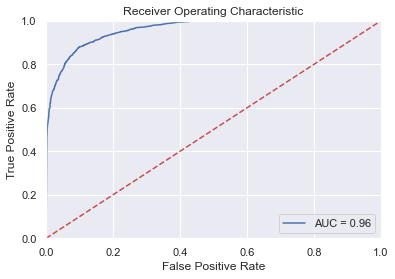

In [38]:
plot_auc_curve(fpr,tpr)

## Model 3: XGBoost

### 3.1 Make pipeline and fit

In [39]:
from xgboost import XGBRegressor

In [40]:
xg_reg = XGBRegressor()

In [41]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [42]:
model_name = xg_reg

### 3.2 Hyperparameter search using GridSearchCV

In [43]:
model_name.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [44]:
grid_params = {'learning_rate': [0.001, 0.01, 0.1],
                'max_depth': [5, 10, 15]}

In [45]:
xg_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)

In [46]:
xg_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1,
                                    enable_categorical=False, gamma=0,
                                    gpu_id=-1, importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=8,
                                    num_parallel_tree=1, predictor='auto',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', vali

In [47]:
xg_grid_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 5}

### 3.3 Model tuneup using best params

In [48]:
xg_reg2=XGBRegressor(learning_rate = 0.1, max_depth= 5)
xg_reg2.fit(X_train,y_train)
print("score",xg_reg2.score(X_test,y_test))

score 0.7019839324792999


In [49]:
y_pred_xg = xg_reg2.predict(X_test)

In [50]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_xg)
metrics.auc(fpr, tpr)

0.9662281176987532

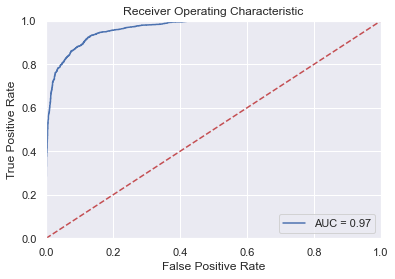

In [51]:
plot_auc_curve(fpr,tpr)

## Model 4: Decision Tree Classifier

### 4.1 Make pipeline and fit

In [52]:
from sklearn import tree

In [53]:
dtree = tree.DecisionTreeClassifier()

In [54]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [55]:
model_name = dtree

### 4.2 Hyperparameter search using GridSearchCV

In [56]:
model_name.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [57]:
grid_params = {'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6,8,10,12]}

In [58]:
dtree_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)

In [59]:
dtree_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]})

In [60]:
dtree_grid_cv.best_params_

{'criterion': 'entropy', 'max_depth': 8}

### 4.3 Model Tuneup using best params

In [105]:
dtree2=tree.DecisionTreeClassifier(criterion= 'entropy', max_depth= 8)
dtree2.fit(X_train,y_train)
print("score",dtree2.score(X_test,y_test))

score 0.8856299575724036


In [106]:
y_pred_dtree = dtree2.predict(X_test)

In [107]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_dtree)
metrics.auc(fpr, tpr)

0.8855788617691402

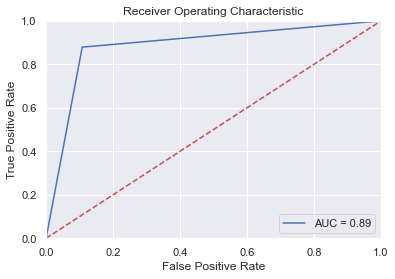

In [108]:
plot_auc_curve(fpr,tpr)

## Model 5: Naive Bayes

### 5.1 Make pipeline and fit

In [65]:
from sklearn.naive_bayes import GaussianNB

In [66]:
gnb = GaussianNB()

In [67]:
gnb.fit(X_train, y_train)

GaussianNB()

In [68]:
model_name = gnb

### 5.2 Hyperparameter search using GridSearchCV

In [69]:
model_name.get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [70]:
grid_params={'var_smoothing': [1e-8, 1e-9, 1e-10, 1e-11, 1e-12]}

In [71]:
gnb_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)

In [72]:
gnb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-08, 1e-09, 1e-10, 1e-11, 1e-12]})

In [73]:
gnb_grid_cv.best_params_

{'var_smoothing': 1e-12}

### 5.3 Model Tuneup using best params

In [74]:
gnb2=GaussianNB(var_smoothing = 1e-12)
gnb2.fit(X_train,y_train)
print("score",gnb2.score(X_test,y_test))

score 0.7308614646744143


In [75]:
y_pred_gnb = gnb2.predict(X_test)

In [76]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_gnb)
metrics.auc(fpr, tpr)

0.7291075783504947

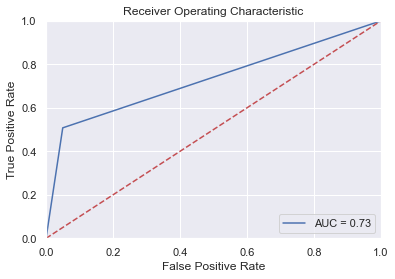

In [77]:
plot_auc_curve(fpr,tpr)

 ## 6. Compare different Models

In [109]:
model = [lr2, rf2, xg_reg2, dtree2, gnb2 ]
model_name =['LogisticRegression', 'RandomForest', 'XGBoost', 'Decision Tree', 'Naive Bayes']

### 6.1 AUC Score

In [110]:
for i, name in enumerate(model):
    val = auc_score(model[i], y_test, X_test)
    print('The AUC Socre for %s is %.4f' % (model_name[i],val))

The AUC Socre for LogisticRegression is 0.6162
The AUC Socre for RandomForest is 0.9599
The AUC Socre for XGBoost is 0.9662
The AUC Socre for Decision Tree is 0.8856
The AUC Socre for Naive Bayes is 0.7291


### 6.2 Save the best models

In [111]:
import pickle
imp_model = [rf2,xg_reg2]
imp_model_name =['RandomForest', 'XGBoost']

for i in range(len(imp_model)):
    filepath = '../models/'+ imp_model_name[i]+'.pkl'
    pickle.dump(imp_model[i], open(filepath, 'wb'))
